GCN

In [2]:
import numpy as np
np.random.seed(0)

In [3]:
A = np.array([[1,1,1,1],
              [1,1,0,0],
              [1,0,1,1],
              [1,0,1,1]])
print(A)

[[1 1 1 1]
 [1 1 0 0]
 [1 0 1 1]
 [1 0 1 1]]


In [ ]:
X = np.random.uniform(-1,1,(4,4)) #노드 특성값
print(X)

[[ 0.09762701  0.43037873  0.20552675  0.08976637]
 [-0.1526904   0.29178823 -0.12482558  0.783546  ]
 [ 0.92732552 -0.23311696  0.58345008  0.05778984]
 [ 0.13608912  0.85119328 -0.85792788 -0.8257414 ]]


In [ ]:
W = np.random.uniform(-1,1,(2,4)) #행렬 W의 차원 = (출력 차원, 입력 차원)
print(W)

[[-0.95956321  0.66523969  0.5563135   0.7400243 ]
 [ 0.95723668  0.59831713 -0.07704128  0.56105835]]


In [ ]:
W_att = np.random.uniform(-1,1,(1,4)) #어텐션 W의 차원 = (1, 은닉층 x 2) = additive 방식이므로.
print(W_att)

[[-0.76345115  0.27984204 -0.71329343  0.88933783]]


In [ ]:
connections = np.where(A>0) #엣지를 탐색
print(connections)

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]), array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))


In [ ]:
print(np.concatenate([(X@W.T)[connections[0]],(X@W.T)[connections[1]]],axis=1)) #열 방향


[[ 0.37339233  0.38548525  0.37339233  0.38548525]
 [ 0.37339233  0.38548525  0.85102612  0.47765279]
 [ 0.37339233  0.38548525 -0.67755906  0.73566587]
 [ 0.37339233  0.38548525 -0.65268413  0.24235977]
 [ 0.85102612  0.47765279  0.37339233  0.38548525]
 [ 0.85102612  0.47765279  0.85102612  0.47765279]
 [-0.67755906  0.73566587  0.37339233  0.38548525]
 [-0.67755906  0.73566587 -0.67755906  0.73566587]
 [-0.67755906  0.73566587 -0.65268413  0.24235977]
 [-0.65268413  0.24235977  0.37339233  0.38548525]
 [-0.65268413  0.24235977 -0.67755906  0.73566587]
 [-0.65268413  0.24235977 -0.65268413  0.24235977]]


In [15]:
a = W_att @ (np.concatenate([(X@W.T)[connections[0]],(X@W.T)[connections[1]]],axis=1)).T
print(a)

[[-0.1007035  -0.35942847  0.96036209  0.50390318 -0.43956122 -0.69828618
   0.79964181  1.8607074   1.40424849  0.64260322  1.70366881  1.2472099 ]]


In [10]:
connections[0]

array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3])

In [16]:
def leaky_relu(x,alpha=0.2):
    return np.maximum(alpha*x,x)
e = leaky_relu(a)
print(e)

[[-0.0201407  -0.07188569  0.96036209  0.50390318 -0.08791224 -0.13965724
   0.79964181  1.8607074   1.40424849  0.64260322  1.70366881  1.2472099 ]]


In [17]:
E = np.zeros(A.shape)
E[connections[0],connections[1]] = e[0]
print(E)

[[-0.0201407  -0.07188569  0.96036209  0.50390318]
 [-0.08791224 -0.13965724  0.          0.        ]
 [ 0.79964181  0.          1.8607074   1.40424849]
 [ 0.64260322  0.          1.70366881  1.2472099 ]]


In [ ]:
def softmax2D(x,axis):
    e = np.exp(x - np.expand_dims(np.max(x,axis=axis),axis)) #차원 통일
    sum = np.expand_dims(np.sum(e,axis=axis),axis)
    return e / sum

W_alpha = softmax2D(E,1)
print(W_alpha)

[[0.15862414 0.15062488 0.42285965 0.26789133]
 [0.24193418 0.22973368 0.26416607 0.26416607]
 [0.16208847 0.07285714 0.46834625 0.29670814]
 [0.16010498 0.08420266 0.46261506 0.2930773 ]]


In [19]:
H = A.T @ W_alpha @ X @ W.T
print(H)

[[-1.10126376  1.99749693]
 [-0.33950544  0.97045933]
 [-1.03570438  1.53614075]
 [-1.03570438  1.53614075]]


PyG - GCN

In [23]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='.',name='Cora')
data= dataset[0]

Processing...
Done!


In [24]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear,Dropout

In [26]:
def accuracy(y_pred,y_true):
    return torch.sum(y_pred==y_true) / len(y_true)

In [39]:
class GAT(torch.nn.Module):
    def __init__(self,dim_in,dim_h,dim_out,heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in,dim_h,heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads,dim_out,heads=1)
    
    def forward(self,x,edge_index):
        h = F.dropout(x,p=0.6,training=self.training)
        h = self.gat1(h,edge_index)
        h = F.elu(h)
        h = F.dropout(h,p=0.6,training=self.training)
        h = self.gat2(h,edge_index)
        return h
    
    def fit(self,data,epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),lr=0.01,weight_decay=0.01)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x,data.edge_index)
            loss = criterion(out[data.train_mask],data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch%20==0:
                val_loss = criterion(out[data.val_mask],data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),data.y[data.val_mask])
                print(f'Epoch : {epoch:>5} | Train_Acc : {acc*100:.4f} | Train_Loss : {loss:.4f} | Val_Acc : {val_acc*100:.4f} | Val_Loss : {val_loss:.4f}')
        
    @torch.no_grad()
    def test(self,data):
        self.eval()
        out = self(data.x,data.edge_index)
        acc = accuracy(out[data.test_mask].argmax(dim=1),data.y[data.test_mask])
        return acc
    

In [40]:
gat = GAT(dataset.num_features,32,dataset.num_classes)
gat.fit(data,epochs=100)

Epoch :     0 | Train_Acc : 23.5714 | Train_Loss : 1.9501 | Val_Acc : 17.8000 | Val_Loss : 1.9379
Epoch :    20 | Train_Acc : 99.2857 | Train_Loss : 0.2015 | Val_Acc : 70.8000 | Val_Loss : 0.9433
Epoch :    40 | Train_Acc : 97.8571 | Train_Loss : 0.1693 | Val_Acc : 74.2000 | Val_Loss : 0.8771
Epoch :    60 | Train_Acc : 97.8571 | Train_Loss : 0.1647 | Val_Acc : 72.2000 | Val_Loss : 0.9017
Epoch :    80 | Train_Acc : 97.8571 | Train_Loss : 0.1618 | Val_Acc : 73.6000 | Val_Loss : 0.8961
Epoch :   100 | Train_Acc : 98.5714 | Train_Loss : 0.1337 | Val_Acc : 74.0000 | Val_Loss : 0.8756


In [41]:
acc = gat.test(data)
print(f'Test_Acc : {acc*100:.4f}')

Test_Acc : 79.5000


CiteSeer DataSet

In [42]:
dataset = Planetoid(root='.',name='CiteSeer')
data = dataset[0]

Processing...
Done!


In [43]:
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

<BarContainer object of 32 artists>

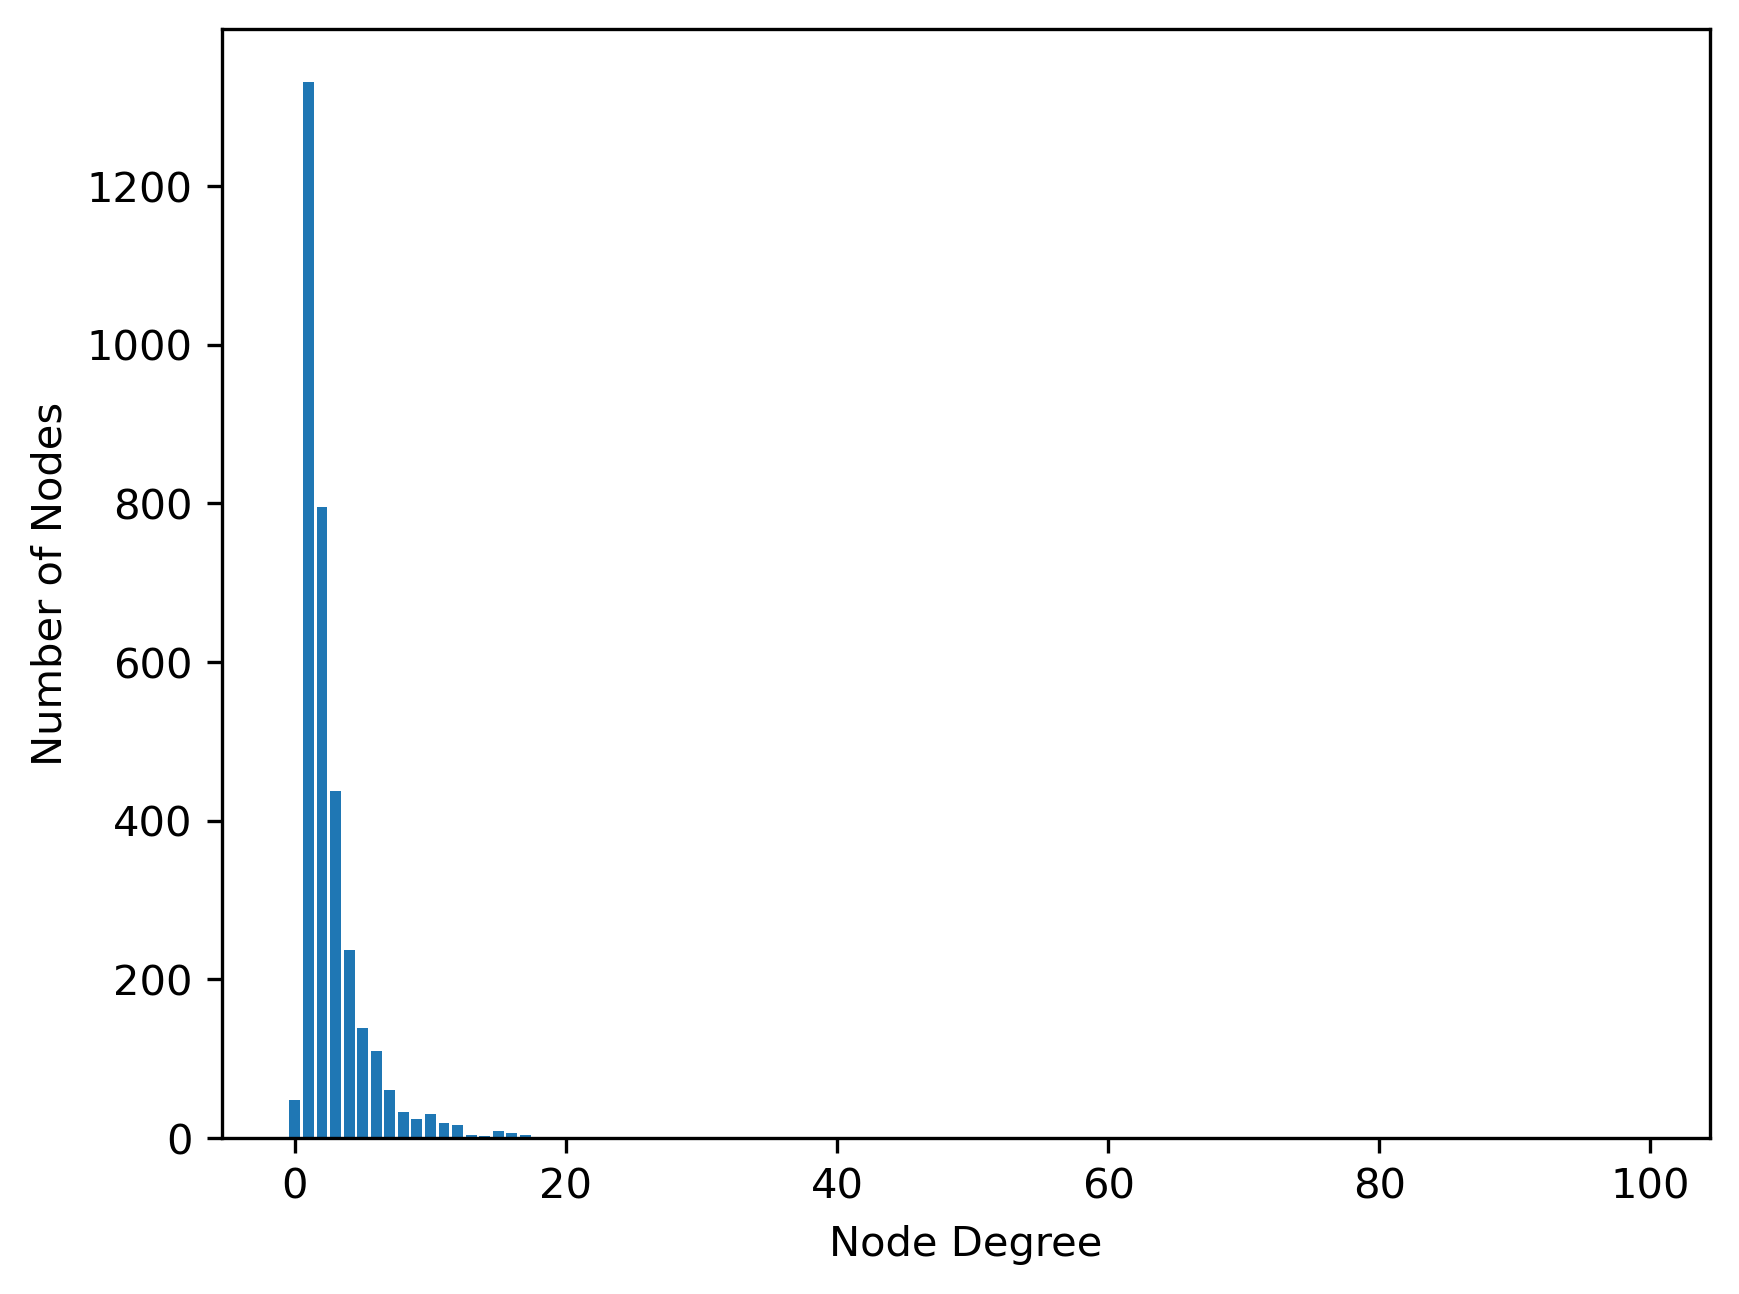

In [44]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

degrees = degree(data.edge_index[0]).numpy()
numbers = Counter(degrees)

fig,ax = plt.subplots(dpi=300)
ax.set_xlabel('Node Degree')
ax.set_ylabel('Number of Nodes')
plt.bar(numbers.keys(),numbers.values())

In [50]:
gat2 = GAT(dataset.num_features,16,dataset.num_classes)
print(gat2)

GAT(
  (gat1): GATv2Conv(3703, 16, heads=8)
  (gat2): GATv2Conv(128, 6, heads=1)
)


In [51]:
gat2.fit(data,epochs=100)

Epoch :     0 | Train_Acc : 23.3333 | Train_Loss : 1.7670 | Val_Acc : 19.6000 | Val_Loss : 1.8039
Epoch :    20 | Train_Acc : 97.5000 | Train_Loss : 0.1759 | Val_Acc : 63.4000 | Val_Loss : 1.0930
Epoch :    40 | Train_Acc : 99.1667 | Train_Loss : 0.1462 | Val_Acc : 60.8000 | Val_Loss : 1.2111
Epoch :    60 | Train_Acc : 99.1667 | Train_Loss : 0.1105 | Val_Acc : 61.8000 | Val_Loss : 1.1706
Epoch :    80 | Train_Acc : 98.3333 | Train_Loss : 0.1178 | Val_Acc : 65.0000 | Val_Loss : 1.0808
Epoch :   100 | Train_Acc : 98.3333 | Train_Loss : 0.1550 | Val_Acc : 62.6000 | Val_Loss : 1.1542


In [52]:
acc = gat2.test(data)
print(f'Test_ACC : {acc*100:.4f}%')

Test_ACC : 69.9000%


In [53]:
out = gat2(data.x,data.edge_index)
degrees = degree(data.edge_index[0]).numpy()

In [ ]:
out.shape #3327개 노드별로 6개의 클래스에 대한 로짓

torch.Size([3327, 6])

In [ ]:
accuracies = []
sizes = []

for i in range(0,6):
    mask = np.where(degrees==i)[0] #차수별로 인덱싱
    accuracies.append(accuracy(out[mask].argmax(dim=1),data.y[mask])) 
    sizes.append(len(mask))

In [73]:
mask = np.where(degrees>5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask],data.y[mask]))
sizes.append(len(mask))

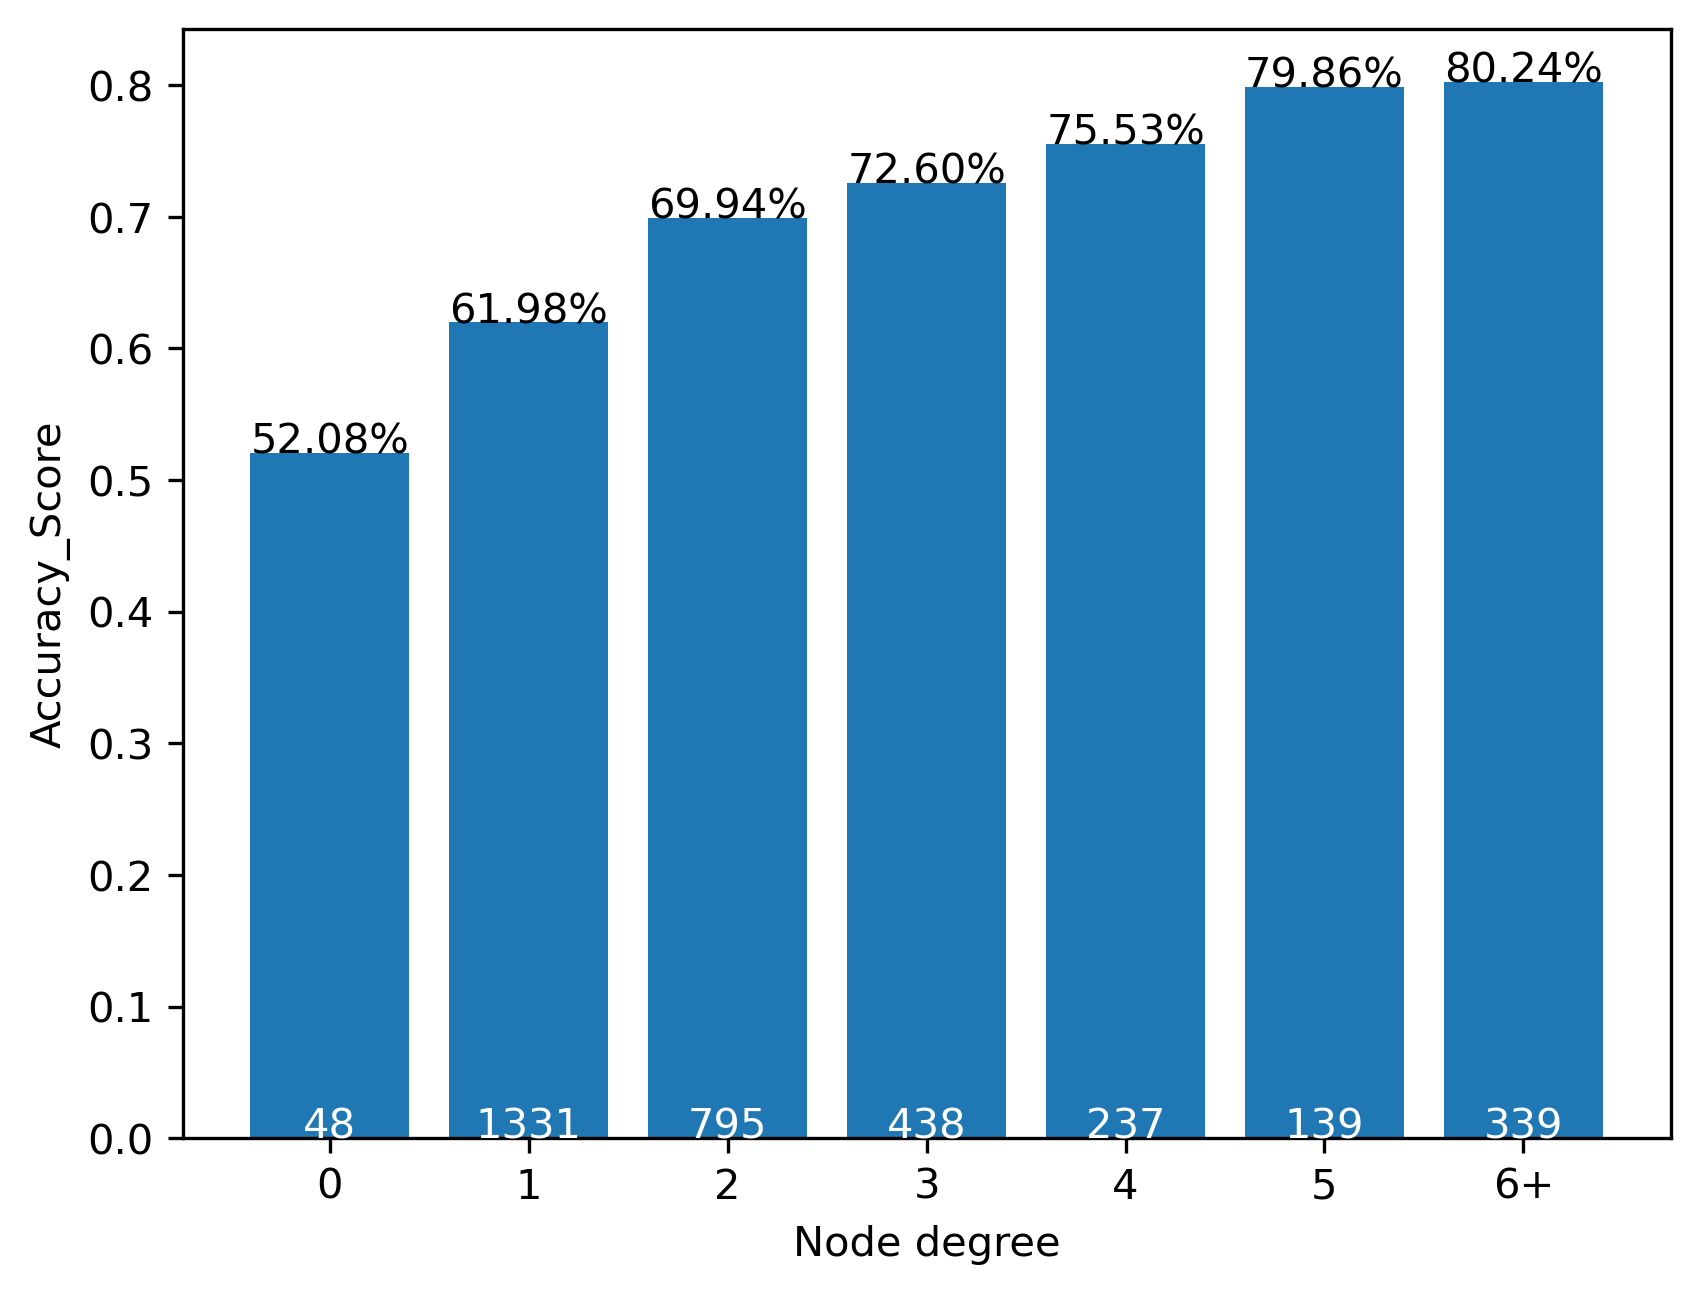

In [81]:
#노드 차수에 따른 정확도 검사
#차수와 정확도는 비례함 => 이웃의 정보가 많기 때문에 더 많은 정보를 GNN이 제공받음.
fig,ax = plt.subplots(dpi=300)
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy_Score')
plt.bar(['0','1','2','3','4','5','6+'],accuracies)
for i in range(0,7):
    plt.text(i,accuracies[i],f'{accuracies[i]*100:.2f}%', ha='center',color='black')
for i in range(0,7):
    plt.text(i,accuracies[i]//2,sizes[i],ha='center',color='white')